# **PREPROCESSING**

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
from tqdm import tqdm
import json
from math import sqrt

# ---------------------------
# 1. KONFIGURASI ENV & MEDIAPIPE
# ---------------------------
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# Indeks Landmark MediaPipe
LEFT_EYE = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]
NOSE_TIP = 1
CHIN = 152

# Hyperparameters
SEQUENCE_LENGTH = 30
FPS = 30
EAR_THRESHOLD = 0.22
MAR_THRESHOLD = 0.3
NODDING_THRESHOLD = 15
FACE_DETECTION_THRESHOLD = 0.05

# ---------------------------
# 2. FUNGSI GEOMETRI & NUMERIK
# ---------------------------
def euclidean_distance(point1, point2):
    return sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2 + (point1.z - point2.z)**2)

def calculate_ear(landmarks, indices):
    p = indices
    v1 = euclidean_distance(landmarks[p[1]], landmarks[p[5]])
    v2 = euclidean_distance(landmarks[p[2]], landmarks[p[4]])
    h = euclidean_distance(landmarks[p[0]], landmarks[p[3]])
    if h < 1e-6: return 0.0
    return (v1 + v2) / (2.0 * h)

def calculate_robust_mar(landmarks):
    # Normalized MAR (Tahan Side View)
    mouth_open = euclidean_distance(landmarks[13], landmarks[14])
    face_vertical_ref = euclidean_distance(landmarks[NOSE_TIP], landmarks[CHIN])
    if face_vertical_ref < 1e-6: return 0.0
    return mouth_open / face_vertical_ref

def estimate_pose_and_yaw(landmarks, w, h):
    face_3d = np.array([
        [0.0, 0.0, 0.0], [0.0, -150.0, -125.0], [0.0, 150.0, -125.0],
        [-150.0, -125.0, 100.0], [150.0, -125.0, 100.0], [0.0, 0.0, 175.0]
    ], dtype=np.float64)
    face_2d = np.array([
        [landmarks[1].x * w, landmarks[1].y * h],
        [landmarks[61].x * w, landmarks[61].y * h],
        [landmarks[291].x * w, landmarks[291].y * h],
        [landmarks[33].x * w, landmarks[33].y * h],
        [landmarks[263].x * w, landmarks[263].y * h],
        [landmarks[10].x * w, landmarks[10].y * h]
    ], dtype=np.float64)
    cam_matrix = np.array([[w, 0, w/2], [0, w, h/2], [0, 0, 1]])
    try:
        success, rot, _ = cv2.solvePnP(face_3d, face_2d, cam_matrix, np.zeros((4,1)))
        if success:
            rmat, _ = cv2.Rodrigues(rot)
            angles, _, _, _, _, _ = cv2.RQDecomp3x3(rmat)
            return angles[0], -angles[1], angles[2]
    except: pass
    return 0.0, 0.0, 0.0

# ---------------------------
# 3. EKSTRAKSI FITUR (ADAPTIVE + FORWARD FILL)
# ---------------------------
def extract_features_adaptive(frame, prev_features=None):
    # Resize untuk speed
    target_w = 480
    h_orig, w_orig = frame.shape[:2]
    scale = target_w / w_orig if w_orig > target_w else 1.0
    if scale < 1.0:
        proc_frame = cv2.resize(frame, (0,0), fx=scale, fy=scale)
    else:
        proc_frame = frame

    rgb = cv2.cvtColor(proc_frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    # Forward Fill Logic
    if not results.multi_face_landmarks:
        if prev_features is not None:
            safe = prev_features.copy()
            safe[9] = 0.0 # Face flag 0 (Wajah hilang)
            return safe
        else:
            d = np.zeros(12)
            d[0], d[1] = 0.3, 0.3
            return d

    lm = results.multi_face_landmarks[0].landmark
    try:
        pitch, yaw, roll = estimate_pose_and_yaw(lm, w_orig, h_orig)
        ear_l = calculate_ear(lm, LEFT_EYE)
        ear_r = calculate_ear(lm, RIGHT_EYE)

        # Side-Aware Logic
        if yaw > 30: avg_ear = ear_r
        elif yaw < -30: avg_ear = ear_l
        else: avg_ear = (ear_l + ear_r) / 2.0

        mar = calculate_robust_mar(lm)

        perclos, blink_dur, yawn_dur = 0.0, 0.0, 0.0
        if prev_features is not None:
            if avg_ear < EAR_THRESHOLD:
                perclos = min(prev_features[3] + 0.05, 1.0)
                blink_dur = prev_features[4] + (1/FPS)
            else:
                perclos = max(prev_features[3] - 0.02, 0.0)
                blink_dur = 0.0

            if mar > MAR_THRESHOLD:
                yawn_dur = prev_features[5] + (1/FPS)
            else:
                yawn_dur = max(0, prev_features[5] - 0.1)

        nodding = 1.0 if pitch > NODDING_THRESHOLD else 0.0
        gaze = 1.0 - np.std([ear_l, ear_r])

        feats = np.array([
            ear_l, ear_r, mar, perclos, blink_dur, yawn_dur,
            pitch, yaw, roll, 1.0, nodding, gaze
        ])
        return feats

    except Exception:
        return prev_features if prev_features is not None else np.zeros(12)

# ---------------------------
# 4. SIGNAL SMOOTHING
# ---------------------------
def smooth_sequence_features(sequence_data, window_size=5):
    """
    Smoothing sinyal EAR/MAR/Pose dalam satu sequence.
    Penting untuk mengurangi jitter akibat kacamata.
    """
    smoothed_data = sequence_data.copy()
    # Indeks: EAR_L(0), EAR_R(1), MAR(2), Pitch(6), Yaw(7), Roll(8), Gaze(11)
    target_indices = [0, 1, 2, 6, 7, 8, 11]
    kernel = np.ones(window_size) / window_size

    for i in target_indices:
        smoothed = np.convolve(sequence_data[:, i], kernel, mode='same')
        smoothed_data[:, i] = smoothed
    return smoothed_data

# ---------------------------
# 5. SEQUENCE GENERATOR (Group ID Included)
# ---------------------------
def create_sequences(video_path, label, subject_id):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()

    if total_frames < SEQUENCE_LENGTH: return [], [], []

    start_indices = []
    # Augmentasi Data (Overlap)
    if label == 1:
        stride = 5  # Drowsiness: Rapat
        for i in range(0, total_frames - SEQUENCE_LENGTH, stride):
            start_indices.append(i)
    else:
        stride = 15 # Normal: Sedang
        for i in range(0, total_frames - SEQUENCE_LENGTH, stride):
            start_indices.append(i)

    # Limit max samples
    if len(start_indices) > 50:
        indices = np.linspace(0, len(start_indices)-1, 50, dtype=int)
        start_indices = [start_indices[k] for k in indices]

    sequences = []
    labels = []
    groups = [] # Menyimpan ID Subjek

    cap = cv2.VideoCapture(video_path)
    all_frames = []
    while True:
        ret, f = cap.read()
        if not ret: break
        all_frames.append(f)
    cap.release()

    for start in start_indices:
        chunk = all_frames[start : start+SEQUENCE_LENGTH]
        if len(chunk) != SEQUENCE_LENGTH: continue

        seq_feats = []
        prev = None

        for frame in chunk:
            feats = extract_features_adaptive(frame, prev)
            seq_feats.append(feats)
            prev = feats

        # Apply Smoothing
        seq_feats_np = np.array(seq_feats)
        seq_feats_smoothed = smooth_sequence_features(seq_feats_np, window_size=5)

        sequences.append(seq_feats_smoothed)
        labels.append(label)
        groups.append(subject_id) # Simpan ID pemilik video ini

    return sequences, labels, groups

In [ ]:
# ---------------------------
# 6. MAIN PROCESSOR (CV MODE)
# ---------------------------
def prepare_data_for_cv(metadata_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    df = pd.read_csv(metadata_path)

    X_all = []
    y_all = []
    groups_all = []

    print("Processing Numeric Dataset for Cross-Validation...")

    for _, row in tqdm(df.iterrows(), total=len(df)):
        if not os.path.exists(row['video_path']): continue

        # Proses video
        s, l, g = create_sequences(row['video_path'], row['label'], row['subject_id'])
        if s:
            X_all.extend(s)
            y_all.extend(l)
            groups_all.extend(g)

    # Convert ke Numpy
    X_all = np.array(X_all, dtype=np.float32) # (N, 30, 12)
    y_all = np.array(y_all, dtype=np.int32)
    groups_all = np.array(groups_all) # Array Subject ID

    print(f"\nCollected Sequences: {len(y_all)}")
    print(f"Unique Subjects: {len(np.unique(groups_all))}")

    # Filtering Data Rusak (Optional, Threshold rendah)
    face_ratios = X_all[:, :, 9].mean(axis=1) # Index 9 is face_flag
    mask = face_ratios >= FACE_DETECTION_THRESHOLD

    X_all = X_all[mask]
    y_all = y_all[mask]
    groups_all = groups_all[mask]

    print(f"Post-Filtering Count: {len(y_all)}")

    # --- PENTING: JANGAN NORMALISASI DI SINI ---
    # Untuk CV yang benar, normalisasi (hitung mean/std) harus dilakukan
    # di dalam loop training per-fold agar tidak bocor.
    # simpan data MENTAH (tapi sudah di-smooth).

    save_path = os.path.join(output_dir, "numeric_data_cv.npz")
    np.savez_compressed(
        save_path,
        X=X_all,
        y=y_all,
        groups=groups_all
    )

    print(f"\n✅ CV-Ready Dataset Saved to: {save_path}")
    print("Files contained: 'X', 'y', 'groups'")
    print("NOTE: Data belum dinormalisasi. Lakukan normalisasi di training loop.")

if __name__ == "__main__":
    prepare_data_for_cv("metadata_process2.csv", "numeric_cv_data_non2")

# **VISUALISASI**

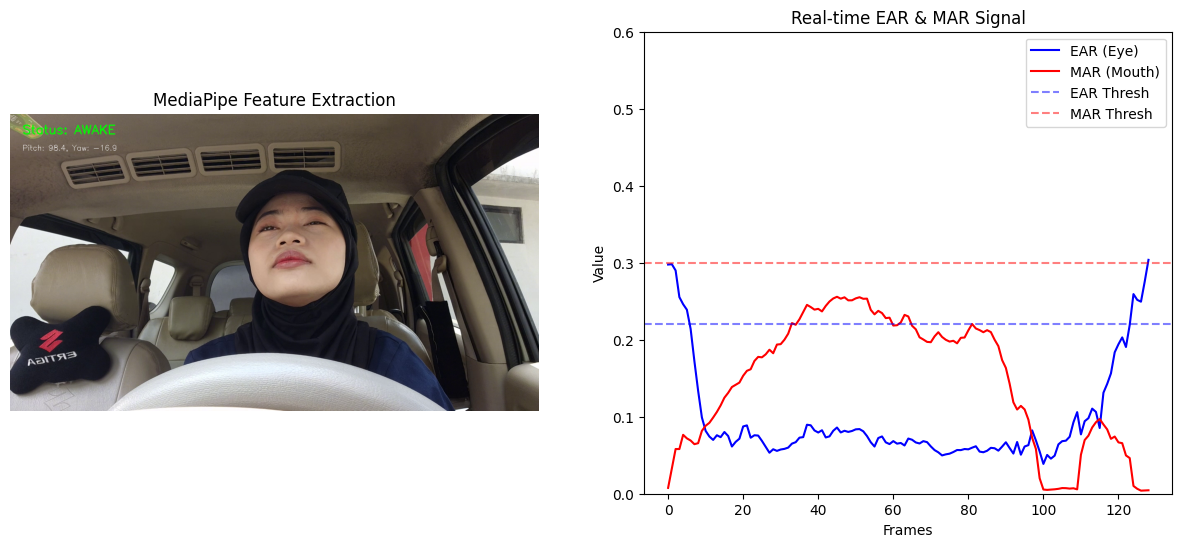

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

def visualize_preprocessing(video_path, limit_frames=150):
    cap = cv2.VideoCapture(video_path)

    # List untuk menyimpan data plot
    ear_history = []
    mar_history = []
    prev_feats = None

    # Setup Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    count = 0
    while cap.isOpened() and count < limit_frames:
        ret, frame = cap.read()
        if not ret: break

        # Ekstraksi fitur menggunakan fungsi Anda
        # Kita panggil extract_features_adaptive yang sudah Anda buat
        feats = extract_features_adaptive(frame, prev_feats)
        prev_feats = feats

        # Data untuk plot (EAR_avg, MAR)
        avg_ear = (feats[0] + feats[1]) / 2
        mar = feats[2]
        ear_history.append(avg_ear)
        mar_history.append(mar)

        # 1. Visualisasi Gambar (Frame)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Gambar indikator di frame
        status = "DROWSY" if avg_ear < EAR_THRESHOLD else "AWAKE"
        color = (255, 0, 0) if status == "DROWSY" else (0, 255, 0)
        cv2.putText(frame_rgb, f"Status: {status}", (30, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
        cv2.putText(frame_rgb, f"Pitch: {feats[6]:.1f}, Yaw: {feats[7]:.1f}", (30, 90),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

        # 2. Update Plot Sinyal
        ax1.clear()
        ax1.imshow(frame_rgb)
        ax1.set_title("MediaPipe Feature Extraction")
        ax1.axis('off')

        ax2.clear()
        ax2.plot(ear_history, label='EAR (Eye)', color='blue')
        ax2.plot(mar_history, label='MAR (Mouth)', color='red')
        ax2.axhline(y=EAR_THRESHOLD, color='blue', linestyle='--', alpha=0.5, label='EAR Thresh')
        ax2.axhline(y=MAR_THRESHOLD, color='red', linestyle='--', alpha=0.5, label='MAR Thresh')
        ax2.set_title("Real-time EAR & MAR Signal")
        ax2.set_xlabel("Frames")
        ax2.set_ylabel("Value")
        ax2.legend(loc='upper right')
        ax2.set_ylim(0, 0.6)

        # Tampilkan di Colab
        clear_output(wait=True)
        display(fig)
        count += 1

    cap.release()
    plt.close()

# Jalankan Visualisasi
visualize_preprocessing('vid_visual/1127.mp4')

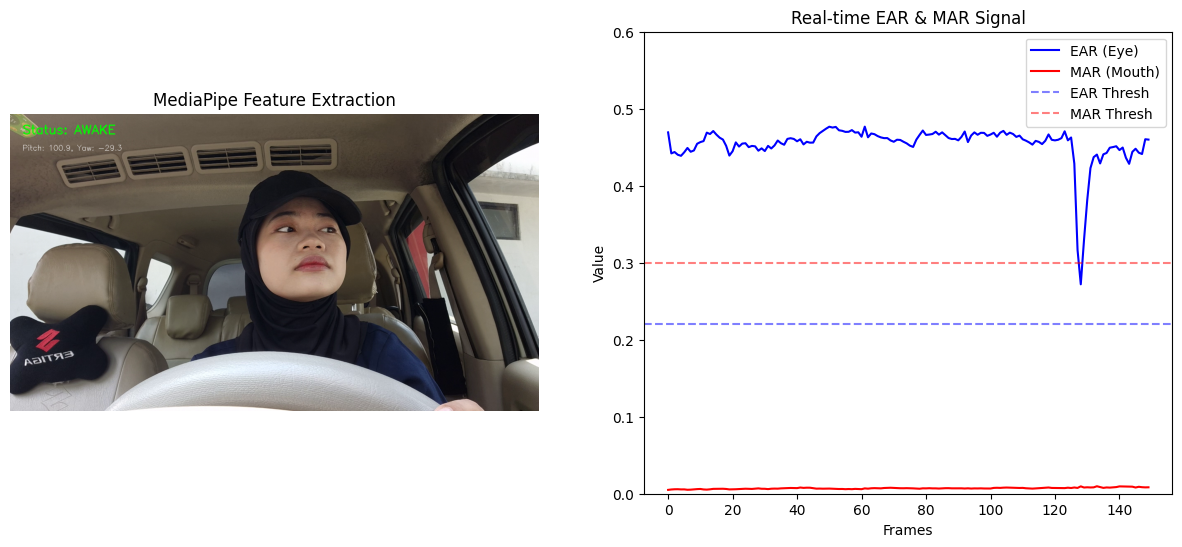

In [ ]:
visualize_preprocessing('vid_visual/front_focus.mp4')

# **MODELING**

## Data Preparation

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import joblib

# ---------------------------
# 1. KONFIGURASI
# ---------------------------
DATA_PATH = "numeric_cv_data_non/numeric_data_cv.npz"
SUBMISSION_TEMPLATE = "metadata_test.csv"
OUTPUT_CSV = "submission_ml.csv"

# ---------------------------
# 2. FEATURE ENGINEERING (STATISTIKAL)
# ---------------------------
def extract_stats(seq_data):
    """
    Mengubah sequence (30, 12) menjadi vector statistik (1, N_Features).
    seq_data shape: (30, 12)
    Fitur: Mean, Std, Max, Min, Skew, Kurtosis, Deltas
    """
    # 12 Fitur Awal:
    # 0:EAR_L, 1:EAR_R, 2:MAR, 3:Perclos, 4:Blink, 5:Yawn,
    # 6-8:Pose, 9:Face, 10:Nod, 11:Gaze

    features = []

    # Ambil fitur kunci saja untuk statistik
    # EAR Avg (0+1)/2, MAR (2), Pitch (6), Yaw (7), Roll (8)
    ear_avg = (seq_data[:, 0] + seq_data[:, 1]) / 2.0
    mar = seq_data[:, 2]
    pitch = seq_data[:, 6]
    yaw = seq_data[:, 7]
    roll = seq_data[:, 8]

    # Kumpulan sinyal yang akan dianalisis
    signals = [ear_avg, mar, pitch, yaw, roll]
    names = ['ear', 'mar', 'pitch', 'yaw', 'roll']

    for sig in signals:
        features.append(np.mean(sig))
        features.append(np.std(sig))
        features.append(np.max(sig))
        features.append(np.min(sig))
        features.append(np.max(sig) - np.min(sig)) # Range
        # features.append(skew(sig)) # Opsional, kadang bikin noise

    # Fitur Khusus: Blink Count (Turun naik)
    # Hitung berapa kali EAR turun dibawah 0.20
    blink_count = np.sum(ear_avg < 0.20)
    features.append(blink_count)

    # Fitur Khusus: Microsleep Duration
    # Berapa frame berturut-turut EAR < 0.20
    closed_frames = ear_avg < 0.20
    max_closed = 0
    current_closed = 0
    for is_closed in closed_frames:
        if is_closed:
            current_closed += 1
        else:
            max_closed = max(max_closed, current_closed)
            current_closed = 0
    max_closed = max(max_closed, current_closed)
    features.append(max_closed)

    # Fitur Khusus: Yawn Duration (MAR > 0.5)
    yawn_frames = np.sum(mar > 0.5)
    features.append(yawn_frames)

    return np.array(features)

## Training

In [ ]:
# ---------------------------
# 3. PREPARE DATASET FOR ML
# ---------------------------
def prepare_ml_data(npz_path):
    print(f"Loading {npz_path}...")
    data = np.load(npz_path)
    X_seq = data['X'] # (N, 30, 12)
    y = data['y']
    groups = data['groups']

    X_ml = []
    print("Extracting Statistical Features...")
    for seq in tqdm(X_seq):
        stats = extract_stats(seq)
        X_ml.append(stats)

    return np.array(X_ml), y, groups

# ---------------------------
# 4. TRAINING (CROSS-VALIDATION)
# ---------------------------
def train_and_evaluate():
    X, y, groups = prepare_ml_data(DATA_PATH)
    print(f"Feature Matrix Shape: {X.shape}")

    # Scaler (Penting untuk SVM/KNN, kurang penting untuk XGB tapi bagus)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Simpan Scaler untuk inference nanti
    joblib.dump(scaler, 'scaler_ml.pkl')

    # --- MODEL SELECTION ---
    model = xgb.XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42
    )

    print(f"Training using: {model.__class__.__name__}")

    # GroupKFold untuk validasi yang jujur
    gkf = GroupKFold(n_splits=5)
    scores = []

    # Kita latih 5 model dan simpan semuanya untuk Voting
    models_list = []

    for fold, (train_idx, val_idx) in enumerate(gkf.split(X_scaled, y, groups)):
        X_train, y_train = X_scaled[train_idx], y[train_idx]
        X_val, y_val = X_scaled[val_idx], y[val_idx]

        # Train
        model.fit(X_train, y_train)

        # Predict
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average='macro')
        scores.append(f1)

        print(f"Fold {fold+1} F1: {f1:.4f}")
        print(classification_report(y_val, preds, target_names=['Non', 'Drowsy']))

        # Simpan model per fold
        models_list.append(model)
        joblib.dump(model, f'model_ml_fold_{fold+1}.pkl')

    print(f"\n🏆 Average CV Score: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    return models_list, scaler

## Infrence On Test Data

In [ ]:
# ---------------------------
# 5. INFERENCE ON TEST DATA
# ---------------------------
def run_test_inference(models_list, scaler):
    # Kita butuh memproses data test dengan cara yang SAMA (Statistical)

    TEST_NPZ = "test_data_numeric_output/test_numeric_sliding.npz"
    if not os.path.exists(TEST_NPZ):
        print("❌ Please run preprocess_test_numeric.py first!")
        return

    print("\nLoading Test Data...")
    data = np.load(TEST_NPZ)
    X_test_seq = data['X_test'] # (N, 30, 12)
    video_ids = data['ids']

    # Feature Engineering
    X_test_ml = []
    for seq in X_test_seq:
        X_test_ml.append(extract_stats(seq))
    X_test_ml = np.array(X_test_ml)

    # Scaling
    X_test_scaled = scaler.transform(X_test_ml)

    # Ensemble Prediction (Voting)
    final_probs = np.zeros((len(X_test_scaled), 2))

    for model in models_list:
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test_scaled)
        else:
            # Fallback untuk model tanpa proba (jarang)
            p = model.predict(X_test_scaled)
            probs = np.zeros((len(p), 2))
            for i, val in enumerate(p): probs[i, val] = 1.0

        final_probs += probs

    final_preds = np.argmax(final_probs, axis=1)

    # Save CSV
    df = pd.DataFrame({'video_id': video_ids, 'label': final_preds})
    df['video_id'] = df['video_id'].astype(str).str.replace('.mp4', '', regex=False)
    df = df.sort_values('video_id')
    df.to_csv(OUTPUT_CSV, index=False)

    print(f"✅ Submission Saved: {OUTPUT_CSV}")
    print(df['label'].value_counts())

if __name__ == "__main__":
    # 1. Train
    trained_models, fitted_scaler = train_and_evaluate()

    # 2. Predict
    run_test_inference(trained_models, fitted_scaler)

Loading numeric_cv_data_non/numeric_data_cv.npz...
Extracting Statistical Features...
100%|██████████| 4022/4022 [00:00<00:00, 11466.16it/s]
Feature Matrix Shape: (4022, 28)
Training using: XGBClassifier
Fold 1 F1: 0.7929
              precision    recall  f1-score   support

         Non       0.87      0.86      0.87       549
      Drowsy       0.71      0.73      0.72       252

    accuracy                           0.82       801
   macro avg       0.79      0.79      0.79       801
weighted avg       0.82      0.82      0.82       801

Fold 2 F1: 0.8730
              precision    recall  f1-score   support

         Non       0.93      0.91      0.92       570
      Drowsy       0.81      0.84      0.83       253

    accuracy                           0.89       823
   macro avg       0.87      0.88      0.87       823
weighted avg       0.89      0.89      0.89       823

Fold 3 F1: 0.7050
              precision    recall  f1-score   support

         Non       0.78      0.87      0.82       532
      Drowsy       0.68      0.52      0.59       280

    accuracy                           0.75       812
   macro avg       0.73      0.70      0.71       812
weighted avg       0.74      0.75      0.74       812

Fold 4 F1: 0.7555
              precision    recall  f1-score   support

         Non       0.76      0.87      0.81       469
      Drowsy       0.78      0.63      0.70       344

    accuracy                           0.77       813
   macro avg       0.77      0.75      0.76       813
weighted avg       0.77      0.77      0.76       813

Fold 5 F1: 0.8896
              precision    recall  f1-score   support

         Non       0.90      0.95      0.92       487
      Drowsy       0.90      0.82      0.86       286

    accuracy                           0.90       773
   macro avg       0.90      0.88      0.89       773
weighted avg       0.90      0.90      0.90       773


🏆 Average CV Score: 0.8032 (+/- 0.0698)

Loading Test Data...
✅ Submission Saved: submission_ml.csv
label
0    367
1    235
Name: count, dtype: int64

## Eksperimen

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import joblib

# ---------------------------
# 1. KONFIGURASI
# ---------------------------
DATA_PATH = "numeric_cv_data_non2/numeric_data_cv.npz"
TEST_NPZ_PATH = "test_data_numeric_output/test_numeric_sliding.npz"
OUTPUT_CSV = "submission_svm3.csv"

# ---------------------------
# 2. FEATURE ENGINEERING (STATISTIKAL)
# ---------------------------
def extract_stats(seq_data):
    """
    Mengubah sequence (30, 12) menjadi vector statistik (1, N_Features).
    seq_data shape: (30, 12)
    Fitur: Mean, Std, Max, Min, Range, Blink Count, Microsleep Duration
    """
    # 12 Fitur Awal:
    # 0:EAR_L, 1:EAR_R, 2:MAR, 3:Perclos, 4:Blink, 5:Yawn,
    # 6-8:Pose, 9:Face, 10:Nod, 11:Gaze

    features = []

    # Ambil fitur kunci saja untuk statistik
    ear_avg = (seq_data[:, 0] + seq_data[:, 1]) / 2.0
    mar = seq_data[:, 2]
    pitch = seq_data[:, 6]
    yaw = seq_data[:, 7]
    roll = seq_data[:, 8]
    gaze = seq_data[:, 11]

    # Kumpulan sinyal yang akan dianalisis
    signals = [ear_avg, mar, pitch, yaw, roll, gaze]

    for sig in signals:
        features.append(np.mean(sig))
        features.append(np.std(sig))
        features.append(np.max(sig))
        features.append(np.min(sig))
        features.append(np.max(sig) - np.min(sig)) # Range

    # --- FITUR KHUSUS (DOMAIN KNOWLEDGE) ---

    # 1. Blink Count (Turun naik) - Hitung berapa kali EAR turun dibawah 0.20
    # Menggunakan diff untuk menghitung transisi open->close
    binary_ear = (ear_avg < 0.20).astype(int)
    transitions = np.diff(binary_ear)
    blink_count = np.sum(transitions == 1) # Hitung transisi masuk ke fase tertutup
    features.append(blink_count)

    # 2. Microsleep Duration (Max consecutive frames mata tertutup)
    closed_frames = ear_avg < 0.20
    max_closed = 0
    current_closed = 0
    for is_closed in closed_frames:
        if is_closed:
            current_closed += 1
        else:
            max_closed = max(max_closed, current_closed)
            current_closed = 0
    max_closed = max(max_closed, current_closed)
    features.append(max_closed)

    # 3. Yawn Duration (MAR > 0.5)
    yawn_frames = np.sum(mar > 0.5)
    features.append(yawn_frames)

    # 4. Head Nodding (Pitch > Threshold secara konsisten)
    nodding_frames = np.sum(pitch > 15)
    features.append(nodding_frames)

    return np.array(features)

# ---------------------------
# 3. PREPARE DATASET FOR ML
# ---------------------------
def prepare_ml_data(npz_path):
    print(f"Loading {npz_path}...")
    data = np.load(npz_path)
    X_seq = data['X'] # (N, 30, 12)
    y = data['y']
    groups = data['groups']

    X_ml = []
    print("Extracting Statistical Features...")
    for seq in tqdm(X_seq):
        stats = extract_stats(seq)
        X_ml.append(stats)

    return np.array(X_ml), y, groups

# ---------------------------
# 4. TRAINING (CROSS-VALIDATION)
# ---------------------------
def train_and_evaluate():
    X, y, groups = prepare_ml_data(DATA_PATH)
    print(f"Feature Matrix Shape: {X.shape}")

    # Menggunakan RobustScaler karena fitur statistik sering punya outlier
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    # Simpan Scaler
    joblib.dump(scaler, 'scaler_ml.pkl')

    # --- PILIHAN MODEL ---

    # 1. SVM (Support Vector Machine) - SANGAT DIREKOMENDASIKAN
    # class_weight='balanced' penting untuk dataset kecil/imbalance
    svm_model = SVC(
        kernel='rbf',
        C=10,             # Regularization parameter
        gamma='scale',    # Kernel coefficient
        probability=True, # Agar bisa predict_proba untuk ensemble
        class_weight='balanced',
        random_state=42
    )

    # --- MODEL UTAMA YANG AKAN DILATIH ---
    model = svm_model

    print(f"Training using: {model.__class__.__name__}")

    gkf = GroupKFold(n_splits=5)
    scores = []
    models_list = []

    print("\nStarting Cross-Validation...")
    for fold, (train_idx, val_idx) in enumerate(gkf.split(X_scaled, y, groups)):
        X_train, y_train = X_scaled[train_idx], y[train_idx]
        X_val, y_val = X_scaled[val_idx], y[val_idx]

        # Train
        model.fit(X_train, y_train)

        # Predict
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average='macro')
        scores.append(f1)

        print(f"Fold {fold+1} F1: {f1:.4f}")
        # print(classification_report(y_val, preds, target_names=['Non', 'Drowsy']))

        # Simpan model (Kita butuh clone fresh model atau fit ulang,
        # tapi untuk sklearn simple fit sudah overwrite)
        # Kita simpan ke disk agar aman
        joblib.dump(model, f'model_ml_fold_{fold+1}.pkl')
        models_list.append(f'model_ml_fold_{fold+1}.pkl') # Simpan path/nama

    print(f"\n🏆 Average CV Score: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

    return models_list, scaler

if __name__ == "__main__":
    # 1. Train SVM
    trained_model_paths, fitted_scaler = train_and_evaluate()

Loading numeric_cv_data_non2/numeric_data_cv.npz...
Extracting Statistical Features...


100%|██████████| 3189/3189 [00:00<00:00, 9222.73it/s]


Feature Matrix Shape: (3189, 34)
Training using: SVC

Starting Cross-Validation...
Fold 1 F1: 0.7559
Fold 2 F1: 0.7712
Fold 3 F1: 0.8149
Fold 4 F1: 0.7506
Fold 5 F1: 0.8263

🏆 Average CV Score: 0.7838 (+/- 0.0310)

Loading Test Data from test_data_numeric_output/test_numeric_sliding.npz...
Extracting Test Features...


100%|██████████| 602/602 [00:00<00:00, 8192.35it/s]

Predicting with Ensemble of CV Models...


✅ Submission Saved: submission_svm3.csv

Class Distribution:
label
0    395
1    207
Name: count, dtype: int64


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import joblib

# ---------------------------
# 1. KONFIGURASI
# ---------------------------
DATA_PATH = "numeric_cv_data_non2/numeric_data_cv.npz"
TEST_NPZ_PATH = "test_data_numeric_output/test_numeric_sliding.npz"
OUTPUT_CSV = "submission_ensemble_voting.csv"

# ---------------------------
# 2. FEATURE ENGINEERING (STATISTIKAL)
# ---------------------------
def extract_stats(seq_data):
    """
    Mengubah sequence (30, 12) menjadi vector statistik (1, N_Features).
    seq_data shape: (30, 12)
    Fitur: Mean, Std, Max, Min, Range, Blink Count, Microsleep Duration
    """
    # 12 Fitur Awal:
    # 0:EAR_L, 1:EAR_R, 2:MAR, 3:Perclos, 4:Blink, 5:Yawn,
    # 6-8:Pose, 9:Face, 10:Nod, 11:Gaze

    features = []

    # Ambil fitur kunci saja untuk statistik
    ear_avg = (seq_data[:, 0] + seq_data[:, 1]) / 2.0
    mar = seq_data[:, 2]
    pitch = seq_data[:, 6]
    yaw = seq_data[:, 7]
    roll = seq_data[:, 8]
    gaze = seq_data[:, 11]

    # Kumpulan sinyal yang akan dianalisis
    signals = [ear_avg, mar, pitch, yaw, roll, gaze]

    for sig in signals:
        features.append(np.mean(sig))
        features.append(np.std(sig))
        features.append(np.max(sig))
        features.append(np.min(sig))
        features.append(np.max(sig) - np.min(sig)) # Range

    # --- FITUR KHUSUS (DOMAIN KNOWLEDGE) ---

    # 1. Blink Count (Turun naik) - Hitung berapa kali EAR turun dibawah 0.20
    # Menggunakan diff untuk menghitung transisi open->close
    binary_ear = (ear_avg < 0.20).astype(int)
    transitions = np.diff(binary_ear)
    blink_count = np.sum(transitions == 1) # Hitung transisi masuk ke fase tertutup
    features.append(blink_count)

    # 2. Microsleep Duration (Max consecutive frames mata tertutup)
    closed_frames = ear_avg < 0.20
    max_closed = 0
    current_closed = 0
    for is_closed in closed_frames:
        if is_closed:
            current_closed += 1
        else:
            max_closed = max(max_closed, current_closed)
            current_closed = 0
    max_closed = max(max_closed, current_closed)
    features.append(max_closed)

    # 3. Yawn Duration (MAR > 0.5)
    yawn_frames = np.sum(mar > 0.5)
    features.append(yawn_frames)

    # 4. Head Nodding (Pitch > Threshold secara konsisten)
    nodding_frames = np.sum(pitch > 15)
    features.append(nodding_frames)

    return np.array(features)

# ---------------------------
# 3. PREPARE DATASET FOR ML
# ---------------------------
def prepare_ml_data(npz_path):
    print(f"Loading {npz_path}...")
    data = np.load(npz_path)
    X_seq = data['X'] # (N, 30, 12)
    y = data['y']
    groups = data['groups']

    X_ml = []
    print("Extracting Statistical Features...")
    for seq in tqdm(X_seq):
        stats = extract_stats(seq)
        X_ml.append(stats)

    return np.array(X_ml), y, groups

# ---------------------------
# 4. TRAINING (CROSS-VALIDATION)
# ---------------------------
def train_and_evaluate():
    X, y, groups = prepare_ml_data(DATA_PATH)
    print(f"Feature Matrix Shape: {X.shape}")

    # Gunakan RobustScaler karena fitur statistik sering punya outlier
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    # Simpan Scaler
    joblib.dump(scaler, 'scaler_ml.pkl')

    # --- PILIHAN MODEL ---

    # 1. SVM (Support Vector Machine)
    svm_model = SVC(
        kernel='rbf',
        C=10,             # Regularization parameter
        gamma='scale',    # Kernel coefficient
        probability=True, # Agar bisa predict_proba untuk ensemble
        class_weight='balanced',
        random_state=42
    )

    # 2. Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    # 3. KNN
    knn_model = KNeighborsClassifier(
        n_neighbors=7,
        weights='distance', # Memberi bobot lebih pada tetangga terdekat
        n_jobs=-1
    )

    # --- MODEL UTAMA (ENSEMBLE) ---
    # Menggabungkan SVM, Random Forest, dan KNN menggunakan VotingClassifier
    # Voting 'soft' menggunakan rata-rata probabilitas prediksi.

    model = VotingClassifier(
        estimators=[
            ('svm', svm_model),
            ('rf', rf_model),
            ('knn', knn_model)
        ],
        voting='soft',
        n_jobs=-1
    )

    print(f"Training using: {model.__class__.__name__} (SVM + RF + KNN)")

    gkf = GroupKFold(n_splits=5)
    scores = []
    models_list = []

    print("\nStarting Cross-Validation...")
    for fold, (train_idx, val_idx) in enumerate(gkf.split(X_scaled, y, groups)):
        X_train, y_train = X_scaled[train_idx], y[train_idx]
        X_val, y_val = X_scaled[val_idx], y[val_idx]

        # Train
        model.fit(X_train, y_train)

        # Predict
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average='macro')
        scores.append(f1)

        print(f"Fold {fold+1} F1: {f1:.4f}")
        # print(classification_report(y_val, preds, target_names=['Non', 'Drowsy']))

        # Simpan model
        joblib.dump(model, f'model_ensemble_fold_{fold+1}.pkl')
        models_list.append(f'model_ensemble_fold_{fold+1}.pkl')

    print(f"\n🏆 Average CV Score: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

    return models_list, scaler

# ---------------------------
# 5. INFERENCE ON TEST DATA
# ---------------------------
def run_test_inference(model_paths, scaler):
    if not os.path.exists(TEST_NPZ_PATH):
        print(f"❌ Test data not found at: {TEST_NPZ_PATH}")
        return

    print(f"\nLoading Test Data from {TEST_NPZ_PATH}...")
    data = np.load(TEST_NPZ_PATH)

    # Handle variasi nama key pada file npz (kadang X_test, kadang X_test_num)
    if 'X_test' in data:
        X_test_seq = data['X_test']
    elif 'X_test_num' in data:
        X_test_seq = data['X_test_num']
    else:
        # Fallback coba ambil array pertama
        X_test_seq = data[data.files[0]]

    video_ids = data['ids'] if 'ids' in data else data['video_ids']

    print("Extracting Test Features...")
    X_test_ml = []
    for seq in tqdm(X_test_seq):
        stats = extract_stats(seq)
        X_test_ml.append(stats)
    X_test_ml = np.array(X_test_ml)

    # Scaling
    X_test_scaled = scaler.transform(X_test_ml)

    # Ensemble Prediction (Average Probability dari semua Fold)
    print("Predicting with Ensemble of CV Models...")
    final_probs = np.zeros((len(X_test_scaled), 2))

    for m_path in model_paths:
        model = joblib.load(m_path)
        # VotingClassifier mendukung predict_proba jika voting='soft'
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test_scaled)
        else:
            p = model.predict(X_test_scaled)
            probs = np.zeros((len(p), 2))
            for i, val in enumerate(p): probs[i, val] = 1.0
        final_probs += probs

    final_preds = np.argmax(final_probs, axis=1)

    # Save CSV
    df = pd.DataFrame({'video_id': video_ids, 'label': final_preds})
    # Cleaning ID
    df['video_id'] = df['video_id'].astype(str).str.replace('.mp4', '', regex=False)
    df = df.sort_values('video_id')

    df.to_csv(OUTPUT_CSV, index=False)

    print(f"✅ Submission Saved: {OUTPUT_CSV}")
    print("\nClass Distribution:")
    print(df['label'].value_counts())

if __name__ == "__main__":
    # 1. Train Ensemble (SVM+RF+KNN)
    trained_model_paths, fitted_scaler = train_and_evaluate()

    # 2. Predict Test Data
    run_test_inference(trained_model_paths, fitted_scaler)

Loading numeric_cv_data_non2/numeric_data_cv.npz...
Extracting Statistical Features...


100%|██████████| 3189/3189 [00:00<00:00, 8891.18it/s]

Feature Matrix Shape: (3189, 34)
Training using: VotingClassifier (SVM + RF + KNN)

Starting Cross-Validation...


Fold 1 F1: 0.7610
Fold 2 F1: 0.7769
Fold 3 F1: 0.8222
Fold 4 F1: 0.7553
Fold 5 F1: 0.8476

🏆 Average CV Score: 0.7926 (+/- 0.0362)

Loading Test Data from test_data_numeric_output/test_numeric_sliding.npz...
Extracting Test Features...


100%|██████████| 602/602 [00:00<00:00, 7524.92it/s]

Predicting with Ensemble of CV Models...


✅ Submission Saved: submission_ensemble_voting.csv

Class Distribution:
label
0    411
1    191
Name: count, dtype: int64


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import joblib

# ---------------------------
# 1. KONFIGURASI
# ---------------------------
DATA_PATH = "numeric_cv_data_non2/numeric_data_cv.npz"
TEST_NPZ_PATH = "test_data_numeric_output/test_numeric_sliding.npz"
OUTPUT_CSV = "submission_svm3.csv"

# ---------------------------
# 2. FEATURE ENGINEERING (STATISTIKAL)
# ---------------------------
def extract_stats(seq_data):
    """
    Mengubah sequence (30, 12) menjadi vector statistik (1, N_Features).
    seq_data shape: (30, 12)
    Fitur: Mean, Std, Max, Min, Range, Blink Count, Microsleep Duration
    """
    # 12 Fitur Awal:
    # 0:EAR_L, 1:EAR_R, 2:MAR, 3:Perclos, 4:Blink, 5:Yawn,
    # 6-8:Pose, 9:Face, 10:Nod, 11:Gaze

    features = []

    # Ambil fitur kunci saja untuk statistik
    ear_avg = (seq_data[:, 0] + seq_data[:, 1]) / 2.0
    mar = seq_data[:, 2]
    pitch = seq_data[:, 6]
    yaw = seq_data[:, 7]
    roll = seq_data[:, 8]
    gaze = seq_data[:, 11]

    # Kumpulan sinyal yang akan dianalisis
    signals = [ear_avg, mar, pitch, yaw, roll, gaze]

    for sig in signals:
        features.append(np.mean(sig))
        features.append(np.std(sig))
        features.append(np.max(sig))
        features.append(np.min(sig))
        features.append(np.max(sig) - np.min(sig)) # Range

    # --- FITUR KHUSUS (DOMAIN KNOWLEDGE) ---

    # 1. Blink Count (Turun naik) - Hitung berapa kali EAR turun dibawah 0.20
    # Menggunakan diff untuk menghitung transisi open->close
    binary_ear = (ear_avg < 0.20).astype(int)
    transitions = np.diff(binary_ear)
    blink_count = np.sum(transitions == 1) # Hitung transisi masuk ke fase tertutup
    features.append(blink_count)

    # 2. Microsleep Duration (Max consecutive frames mata tertutup)
    closed_frames = ear_avg < 0.20
    max_closed = 0
    current_closed = 0
    for is_closed in closed_frames:
        if is_closed:
            current_closed += 1
        else:
            max_closed = max(max_closed, current_closed)
            current_closed = 0
    max_closed = max(max_closed, current_closed)
    features.append(max_closed)

    # 3. Yawn Duration (MAR > 0.5)
    yawn_frames = np.sum(mar > 0.5)
    features.append(yawn_frames)

    # 4. Head Nodding (Pitch > Threshold secara konsisten)
    nodding_frames = np.sum(pitch > 15)
    features.append(nodding_frames)

    return np.array(features)

# ---------------------------
# 3. PREPARE DATASET FOR ML
# ---------------------------
def prepare_ml_data(npz_path):
    print(f"Loading {npz_path}...")
    data = np.load(npz_path)
    X_seq = data['X'] # (N, 30, 12)
    y = data['y']
    groups = data['groups']

    X_ml = []
    print("Extracting Statistical Features...")
    for seq in tqdm(X_seq):
        stats = extract_stats(seq)
        X_ml.append(stats)

    return np.array(X_ml), y, groups

# ---------------------------
# 4. TRAINING (CROSS-VALIDATION)
# ---------------------------
def train_and_evaluate():
    X, y, groups = prepare_ml_data(DATA_PATH)
    print(f"Feature Matrix Shape: {X.shape}")

    # Menggunakan RobustScaler karena fitur statistik sering punya outlier
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    # Simpan Scaler
    joblib.dump(scaler, 'scaler_ml.pkl')

    # --- PILIHAN MODEL ---

    # 1. SVM (Support Vector Machine) - SANGAT DIREKOMENDASIKAN
    # class_weight='balanced' penting untuk dataset kecil/imbalance
    svm_model = SVC(
        kernel='rbf',
        C=10,             # Regularization parameter
        gamma='scale',    # Kernel coefficient
        probability=True, # Agar bisa predict_proba untuk ensemble
        class_weight='balanced',
        random_state=42
    )

    # 2. Random Forest - Sebagai pembanding/Ensemble
    rf_model = RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    # --- MODEL UTAMA YANG AKAN DILATIH ---

    model = VotingClassifier(
        estimators=[('svm', svm_model), ('rf', rf_model)],
        voting='soft'
    )

    print(f"Training using: {model.__class__.__name__}")

    gkf = GroupKFold(n_splits=5)
    scores = []
    models_list = []

    print("\nStarting Cross-Validation...")
    for fold, (train_idx, val_idx) in enumerate(gkf.split(X_scaled, y, groups)):
        X_train, y_train = X_scaled[train_idx], y[train_idx]
        X_val, y_val = X_scaled[val_idx], y[val_idx]

        # Train
        model.fit(X_train, y_train)

        # Predict
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds, average='macro')
        scores.append(f1)

        print(f"Fold {fold+1} F1: {f1:.4f}")
        # print(classification_report(y_val, preds, target_names=['Non', 'Drowsy']))

        # Simpan model (Kita butuh clone fresh model atau fit ulang,
        joblib.dump(model, f'model_ml_fold_{fold+1}.pkl')
        models_list.append(f'model_ml_fold_{fold+1}.pkl') # Simpan path/nama

    print(f"\n🏆 Average CV Score: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

    return models_list, scaler

# ---------------------------
# 5. INFERENCE ON TEST DATA
# ---------------------------
def run_test_inference(model_paths, scaler):
    if not os.path.exists(TEST_NPZ_PATH):
        print(f" Test data not found at: {TEST_NPZ_PATH}")
        return

    print(f"\nLoading Test Data from {TEST_NPZ_PATH}...")
    data = np.load(TEST_NPZ_PATH)

    # Handle variasi nama key pada file npz (kadang X_test, kadang X_test_num)
    if 'X_test' in data:
        X_test_seq = data['X_test']
    elif 'X_test_num' in data:
        X_test_seq = data['X_test_num']
    else:
        # Fallback coba ambil array pertama
        X_test_seq = data[data.files[0]]

    video_ids = data['ids'] if 'ids' in data else data['video_ids']

    print("Extracting Test Features...")
    X_test_ml = []
    for seq in tqdm(X_test_seq):
        stats = extract_stats(seq)
        X_test_ml.append(stats)
    X_test_ml = np.array(X_test_ml)

    # Scaling
    X_test_scaled = scaler.transform(X_test_ml)

    # Ensemble Prediction (Average Probability dari semua Fold)
    print("Predicting with Ensemble of CV Models...")
    final_probs = np.zeros((len(X_test_scaled), 2))

    for m_path in model_paths:
        model = joblib.load(m_path)
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test_scaled)
        else:
            p = model.predict(X_test_scaled)
            probs = np.zeros((len(p), 2))
            for i, val in enumerate(p): probs[i, val] = 1.0
        final_probs += probs

    final_preds = np.argmax(final_probs, axis=1)

    # Save CSV
    df = pd.DataFrame({'video_id': video_ids, 'label': final_preds})
    # Cleaning ID
    df['video_id'] = df['video_id'].astype(str).str.replace('.mp4', '', regex=False)
    df = df.sort_values('video_id')

    df.to_csv(OUTPUT_CSV, index=False)

    print(f"✅ Submission Saved: {OUTPUT_CSV}")
    print("\nClass Distribution:")
    print(df['label'].value_counts())

if __name__ == "__main__":
    # 1. Train SVM/RF
    trained_model_paths, fitted_scaler = train_and_evaluate()

    # 2. Predict Test Data
    run_test_inference(trained_model_paths, fitted_scaler)

Loading numeric_cv_data_non2/numeric_data_cv.npz...
Extracting Statistical Features...


100%|██████████| 3189/3189 [00:00<00:00, 4320.04it/s]


Feature Matrix Shape: (3189, 34)
Training using: VotingClassifier

Starting Cross-Validation...
Fold 1 F1: 0.7659
Fold 2 F1: 0.7854
Fold 3 F1: 0.8650
Fold 4 F1: 0.7535
Fold 5 F1: 0.8391

🏆 Average CV Score: 0.8018 (+/- 0.0431)
 Test data not found at: test_data_numeric_output/test_numeric_sliding.npz


# **Hyperparameter Tuning**

In [13]:
import numpy as np
import joblib
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from scipy.stats import loguniform, uniform


# ---------------------------
# 3. PREPARE DATASET FOR ML
# ---------------------------
def prepare_ml_data(npz_path):
    print(f"Loading {npz_path}...")
    data = np.load(npz_path)
    X_seq = data['X'] # (N, 30, 12)
    y = data['y']
    groups = data['groups']

    X_ml = []
    print("Extracting Statistical Features...")
    for seq in tqdm(X_seq):
        stats = extract_stats(seq)
        X_ml.append(stats)

    return np.array(X_ml), y, groups

# ---------------------------
# 1. LOAD & PREPARE DATA
# ---------------------------
def run_hyperparameter_tuning(npz_path):
    # Gunakan fungsi prepare_ml_data yang sudah Anda buat sebelumnya
    X, y, groups = prepare_ml_data(npz_path)

    # Scaling data (Penting untuk SVM)
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    # ---------------------------
    # 2. DEFINISI RUANG PARAMETER
    # ---------------------------
    # Kita menggunakan distribusi log-uniform untuk C dan Gamma
    # karena mereka sensitif terhadap skala besaran (10, 1, 0.1, dst)
    param_distributions = {
        'C': loguniform(1e-1, 1e2),          # Antara 0.1 sampai 100
        'gamma': loguniform(1e-3, 1e0),      # Antara 0.001 sampai 1
        'kernel': ['rbf', 'poly'],           # Mencoba RBF dan Polynomial
        'degree': [2, 3],                    # Hanya untuk kernel poly
        'class_weight': ['balanced', None]   # Mengatasi data tak seimbang
    }

    # ---------------------------
    # 3. SETUP RANDOM SEARCH
    # ---------------------------
    # Gunakan GroupKFold agar video dari orang yang sama tidak bocor ke data validasi
    gkf = GroupKFold(n_splits=5)

    svm = SVC(probability=True, random_state=42)

    random_search = RandomizedSearchCV(
        estimator=svm,
        param_distributions=param_distributions,
        n_iter=20,             # Mencoba 20 kombinasi acak
        scoring='f1_macro',    # Fokus pada performa rata-rata kelas
        cv=gkf,                # Menggunakan GroupKFold
        verbose=2,
        random_state=42,
        n_jobs=-1              # Gunakan semua core CPU
    )

    # ---------------------------
    # 4. RUN TUNING
    # ---------------------------
    print("Memulai Hyperparameter Tuning...")
    random_search.fit(X_scaled, y, groups=groups)

    # Hasil Terbaik
    print("\n" + "="*30)
    print(f"Best Score (F1 Macro): {random_search.best_score_:.4f}")
    print(f"Best Parameters: {random_search.best_params_}")
    print("="*30)

    # Simpan Model Terbaik
    best_model = random_search.best_estimator_
    joblib.dump(best_model, 'best_svm_model_tuned.pkl')
    joblib.dump(scaler, 'scaler_tuned.pkl')

    return best_model

# Jalankan
best_svm = run_hyperparameter_tuning("/content/numeric_data_cv.npz")

Loading /content/numeric_data_cv.npz...
Extracting Statistical Features...


100%|██████████| 3189/3189 [00:02<00:00, 1452.47it/s]


Memulai Hyperparameter Tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Score (F1 Macro): 0.7839
Best Parameters: {'C': np.float64(6.17377039470457), 'class_weight': None, 'degree': 2, 'gamma': np.float64(0.0019949166150633937), 'kernel': 'rbf'}


In [ ]:
import numpy as np
import joblib
import random
from tqdm import tqdm
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from deap import base, creator, tools, algorithms

# ---------------------------
# 3. PREPARE DATASET FOR ML
# ---------------------------
def prepare_ml_data(npz_path):
    print(f"Loading {npz_path}...")
    data = np.load(npz_path)
    X_seq = data['X'] # (N, 30, 12)
    y = data['y']
    groups = data['groups']

    X_ml = []
    print("Extracting Statistical Features...")
    for seq in tqdm(X_seq):
        stats = extract_stats(seq)
        X_ml.append(stats)

    return np.array(X_ml), y, groups

# ---------------------------
# 1. EVALUATION FUNCTION
# ---------------------------
def evaluate_model(individual, X, y, groups, gkf):
    # Mapping individu (gen) ke parameter SVM
    # individual = [C, gamma, kernel_idx, class_weight_idx]
    C = max(0.1, individual[0])
    gamma = max(0.001, individual[1])
    kernel = ['rbf', 'poly'][int(individual[2])]
    class_weight = ['balanced', None][int(individual[3])]

    model = SVC(C=C, gamma=gamma, kernel=kernel, class_weight=class_weight, random_state=42)

    # Cross validation yang mendukung Groups
    scores = cross_val_score(model, X, y, groups=groups, cv=gkf, scoring='f1_macro', n_jobs=-1)
    return (np.mean(scores),)

def run_stable_genetic_tuning(npz_path):
    # Persiapan Data
    X_raw, y, groups = prepare_ml_data(npz_path)
    scaler = RobustScaler()
    X = scaler.fit_transform(X_raw)
    gkf = GroupKFold(n_splits=3) # Gunakan 3 agar lebih cepat saat tuning

    # --- SETUP DEAP (Algoritma Genetika) ---
    if "FitnessMax" in creator.__dict__: del creator.FitnessMax
    if "Individual" in creator.__dict__: del creator.Individual

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    # Definisi Gen: [C, gamma, kernel, class_weight]
    toolbox.register("attr_c", random.uniform, 0.1, 100)
    toolbox.register("attr_gamma", random.uniform, 0.001, 1.0)
    toolbox.register("attr_kernel", random.randint, 0, 1)
    toolbox.register("attr_cw", random.randint, 0, 1)

    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.attr_c, toolbox.attr_gamma, toolbox.attr_kernel, toolbox.attr_cw), n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Register Fungsi Evaluasi & Operator Genetika
    toolbox.register("evaluate", evaluate_model, X=X, y=y, groups=groups, gkf=gkf)
    toolbox.register("mate", tools.cxTwoPoint) # Crossover
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2) # Mutasi
    toolbox.register("select", tools.selTournament, tournsize=3) # Seleksi

    # --- JALANKAN EVOLUSI ---
    population = toolbox.population(n=10) # 10 individu
    NGEN = 5 # 5 generasi agar tidak terlalu lama

    print(f"Memulai Evolusi Genetika (Stable Custom Loop)...")
    for gen in range(NGEN):
        # Jalankan satu generasi
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
        fits = list(map(toolbox.evaluate, offspring))

        for ind, fit in zip(offspring, fits):
            ind.fitness.values = fit

        population = toolbox.select(offspring, k=len(population))

        best_in_gen = tools.selBest(population, 1)[0]
        print(f"Gen {gen+1} | Best F1: {best_in_gen.fitness.values[0]:.4f}")

    # Ambil Pemenang
    best_ind = tools.selBest(population, 1)[0]

    # Re-train model terbaik
    best_params = {
        'C': best_ind[0], 'gamma': best_ind[1],
        'kernel': ['rbf', 'poly'][int(best_ind[2])],
        'class_weight': ['balanced', None][int(best_ind[3])]
    }

    print("\n" + "="*30)
    print(f"Best Params Found: {best_params}")
    print("="*30)

    final_model = SVC(**best_params, probability=True, random_state=42)
    final_model.fit(X, y) # Train pada seluruh data training

    joblib.dump(final_model, 'best_svm_genetic_stable.pkl')
    joblib.dump(scaler, 'scaler_genetic_stable.pkl')

    return final_model

# Jalankan
best_svm = run_stable_genetic_tuning("/content/numeric_data_cv.npz")

Loading /content/numeric_data_cv.npz...
Extracting Statistical Features...
100%|██████████| 3189/3189 [00:02<00:00, 1463.85it/s]Memulai Evolusi Genetika (Stable Custom Loop)...

Gen 1 | Best F1: 0.7517
Gen 2 | Best F1: 0.7843
Gen 3 | Best F1: 0.7843
Gen 4 | Best F1: 0.7881
Gen 5 | Best F1: 0.7881

==============================

Best Params Found:
{'C': 46.893578161799205, 'gamma': -1.0185415695411337, 'kernel': 'rbf', 'class_weight': 'balanced'}